# CNN for HCM Classification

## Importing necessary dependencies

In [1]:
# Necessary Dependencies
import random
import ipynb.fs.full.HCM_Functions as HCM

from scipy import ndimage
from skimage import measure
from scipy import stats
import sklearn as skl
from sklearn import model_selection as m_s
from skimage.transform import rescale
from skimage.transform import resize

import numpy as np
import pandas as pd
import math
import cv2

import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline 

import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

import glob
import os
from os import listdir

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import metrics

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
#config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Pillow Version: 8.1.0


In [2]:
# Check to see if tensorflow detects GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing/Sorting Data

In [3]:
# Load in Image Table
Image_df = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/Final_4ChamberCineTable.xls')
Image_df.head()

,PatientNumber,RowSpacing,ColumnSpacing
0,100,1.25000,1.25000
1,101,1.25000,1.25000
2,103,1.25000,1.25000
3,106,1.40625,1.40625
4,107,1.25000,1.25000


In [ ]:
# Load in Image Table from Sevde's computer
Image_df = pd.read_excel('C:/Users/sevde/OneDrive - Johns Hopkins/current projects/HCM/HCMprojectGit/HCM_Project/Final_4ChamberCineTable.xls')
Image_df.head()

In [4]:
# Load in EHR Table
# Load in Image Table
EHR_df = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/EHR_Data/HCM_EHR_with_VTVF_NSVT_Outcomes.xls')
EHR_df = EHR_df.drop('Unnamed: 0', axis = 1)

In [ ]:
# Load in EHR Table from Sevde's computer
# Load in Image Table
EHR_df = pd.read_excel('C:/Users/sevde/OneDrive - Johns Hopkins/current projects/HCM/HCMprojectGit/HCM_Project/HCM_EHR_with_VTVF_NSVT_Outcomes.xls')
EHR_df = EHR_df.drop('Unnamed: 0', axis = 1)

In [5]:
EHR_df[EHR_df['Adverse_Outcome'] == 1]

,MRN,MRN_MRI,MRI_ID,Last_Name_MRI,First_Name_Initial_MRI,Record_ID,LastName,FirstName,excl_myect,Myectomy,...,ICDimplantation,ICDshock,ICDshock_Number,AntiTachycardiaPacing,HF,Transplantation,Death,Stroke,MI,Adverse_Outcome
3,JH94072597,JH94072597,6,Adkins,T,10002,Adkins,Charles,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
5,JH74119810,JH74119810,8,Aherne,C,10495,Aherne,Michael,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
15,JH74750203,JH74750203,20,Anderson,E,10583,Anderson,Leif,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
16,JH64598450,JH64598450,21,Anarino,R,10215,Anarino,Lee,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20,JH84340069,JH84340069,26,Armentrout,C,10007,Armentrout,Rebecca,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,JH25821941,JH25821941,804,Wishard,T,10771,Wishard,Faye,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
701,JH35704559,JH35704559,808,Wormley-Holston,M,10789,Wormley-Holston,Sarah,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
702,JH94621943,JH94621943,810,Wozniak,S,10881,Wozniak,Krystyna,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
703,JH14037970,JH14037970,811,Wright,D,10148,Wright,Joshua,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [6]:
# Obtain IDs from EHR Data
EHR_IDs = EHR_df['MRI_ID'].values

In [7]:
# Find EHR IDs in the Image df
Image_df = Image_df[Image_df['PatientNumber'].isin(EHR_IDs.astype(str))]
Image_df

,PatientNumber,RowSpacing,ColumnSpacing
0,100,1.250000,1.250000
1,101,1.250000,1.250000
2,103,1.250000,1.250000
3,106,1.406250,1.406250
4,107,1.250000,1.250000
...,...,...,...
634,794,1.250000,1.250000
635,805,1.339286,1.339286
636,811,1.406250,1.406250
637,812,1.339286,1.339286


In [8]:
# Find outcomes for patients in Image_df in EHR_data
Image_IDs = Image_df['PatientNumber'].values

In [9]:
# Add outcomes to Image_df
Outcomes = []
for ids in Image_IDs:
    Outcomes.append(EHR_df[EHR_df['MRI_ID'].astype(str) == ids].Adverse_Outcome.values[0])
Image_df['Outcomes'] = Outcomes

In [10]:
# Total Number of Positive Outcomes
np.sum(Image_df['Outcomes'])

114

In [11]:
# Creating X_res and Y_res columns
# Load images into directory
filepath = '/home/beepul/HCM-Project/Manual_4ChamberCine_wMasks'
TopDirectory = listdir(filepath)

In [16]:
# Creating X_res and Y_res columns
# Load images into directory
filepath = 'C:/Users/sevde/HCMData/Manual_4ChamberCine_wMasks'
TopDirectory = listdir(filepath)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/sevde/HCMData/Manual_4ChamberCine_wMasks'

In [12]:
# Load images of patients listed in Image_df 
masks = []
images = []
for patients in Image_df.PatientNumber:
    path = filepath + '/' + patients
    image_path = path + '/' + listdir(path)[0]
    image_dir = listdir(image_path)
    img_mask = np.asarray(Image.open(image_path + '/' + 'Mask.png'))
    masks.append(img_mask)
    num_frames = len(image_dir) - 1
    img_data = np.zeros((img_mask.shape[0],img_mask.shape[1],num_frames))
    for k in range(num_frames):
        framepath = image_path + '/' + str(k+1) + '.png'
        img_data[:,:,k] = np.asarray(Image.open(framepath))
    images.append(img_data)

In [13]:
# Calculate lengths and widths of image masks
crop_masks = []
crop_images = []
X_res = []
Y_res = []

for i, m in enumerate(masks):
    bbox = measure.regionprops(m.astype('uint8'))[0].bbox
    c_mask = m[bbox[0]:bbox[2],bbox[1]:bbox[3]]
    crop_images.append(images[i][bbox[0]:bbox[2],bbox[1]:bbox[3],:])
    crop_masks.append(c_mask)
    X_res.append(c_mask.shape[1])
    Y_res.append(c_mask.shape[0])

In [14]:
# Add X_res and Y_res columns to Image df
Image_df['X_res'] = X_res
Image_df['Y_res'] = Y_res

In [15]:
# Add X_length and Y_length columns to Image df
Image_df['X_Length'] = Image_df['ColumnSpacing']*Image_df['X_res']
Image_df['Y_Length'] = Image_df['RowSpacing']*Image_df['Y_res']

In [16]:
# Multiply cropped masks and cropped images together to isolate ROIs
roi_image = []
for j, c_m in enumerate(crop_masks):
    roi_image.append(crop_images[j]*c_m.reshape(c_m.shape[0],c_m.shape[1],1))

## Thresholding Function

In [17]:
# Thresholding Function
def Threshold(image,mask):
    pixels = []
    for i in range(image.shape[2]):
        im_slice = image[:,:,i]
        roi = im_slice*mask
        # Gaussian filtering
        blur = cv2.GaussianBlur(roi,(15,15),0)
        pixels = pixels + (np.ndarray.tolist(blur[mask == 1]))
    pixels = np.asarray(pixels)    
    p_98 = np.percentile(pixels,99)
    p_mod = pixels[pixels <= p_98]
    retval,t_img = cv2.threshold(np.asarray(p_mod).astype('uint16'),0,255,cv2.THRESH_OTSU)
    roi_volume = image*mask.reshape(mask.shape[0],mask.shape[1],1)
    threshold_image = (roi_volume > 0) & (roi_volume < retval)
    final_image = np.zeros((threshold_image.shape[0],threshold_image.shape[1],threshold_image.shape[2]))
    for k in range(threshold_image.shape[2]):
        final_image[:,:,k] = cv2.GaussianBlur(threshold_image[:,:,k].astype('float64'),(15,15),0)
    return final_image

In [18]:
def FWHM(image,mask):
    pixels = []
    for i in range(image.shape[2]):
        im_slice = image[:,:,i]
        roi = im_slice*mask
        # Gaussian filtering
        blur = cv2.GaussianBlur(roi,(5,5),0)
        pixels = pixels + (np.ndarray.tolist(blur[mask == 1]))
    pixels = np.asarray(pixels)    
    p_95 = np.percentile(pixels,95)
    p_mod = pixels[pixels <= p_95]
    retval,t_img = cv2.threshold(np.asarray(p_mod).astype('uint16'),0,255,cv2.THRESH_OTSU)
    pixels_1 = pixels[pixels < retval]
    c = np.histogram(pixels_1, bins = 50)
    bin_edges = c[1]
    bin_width = bin_edges[1] - bin_edges[0]
    bin_med = [bin_edges[i] + bin_width for i in range(len(bin_edges) - 1)]
    coeff = np.polyfit(bin_med,c[0],10)
    poly = np.poly1d(coeff)
    vals = poly(bin_med)
    coeff[10] = coeff[10] - (np.max(vals)/2)
    roots = np.roots(coeff)
    imag = roots.imag
    real = abs(roots[imag == 0].real)
    x_max = np.asarray(bin_med)[vals == np.max(vals)]
    real_sort = real[np.argsort(abs(real - x_max))]
    t1 = real_sort[0].real
    t2_poss = real_sort[real_sort >= x_max]
    if np.size(t2_poss) == 0:
        t2 = bin_med[-1]
    else:
        t2 = t2_poss[0]
    roi_volume = image*mask.reshape(mask.shape[0],mask.shape[1],1)
    threshold_image = (roi_volume > 0) & (roi_volume <= t2)
    return threshold_image

In [ ]:
def Filter(threshold_image):
    final_image = np.zeros((threshold_image.shape[0],threshold_image.shape[1],threshold_image.shape[2]))
    for k in range(threshold_image.shape[2]):
        final_image[:,:,k] = cv2.GaussianBlur(threshold_image[:,:,k].astype('float64'),(15,15),0)
    return final_image

In [292]:
# Thresholding using GMM
k = 5
image = crop_images[k]
mask = crop_masks[k]

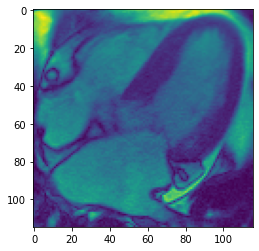

In [293]:
plt.imshow(image[:,:,2])

In [262]:
def neighbor(X):
    kernel = {}
    kernel[1] = np.array([[0,0,0],[0,1,0],[0,0,0]])
    kernel[2] = np.array([[1,0,0],[0,0,0],[0,0,0]])
    kernel[3] = np.array([[0,1,0],[0,0,0],[0,0,0]])
    kernel[4] = np.array([[0,0,1],[0,0,0],[0,0,0]])
    kernel[5] = np.array([[0,0,0],[0,0,1],[0,0,0]])
    kernel[6] = np.array([[0,0,0],[0,0,0],[0,0,1]])
    kernel[7] = kernel[5].T
    kernel[8] = kernel[4].T
    kernel[9] = kernel[3].T
    n_mat = np.zeros((X.size,9))
    for i, k in enumerate(kernel):
        neighbors = cv2.filter2D(X.astype('uint16'),-1,kernel[k],borderType = cv2.BORDER_CONSTANT)
        n_mat[:,i] = np.ravel(neighbors)
    return n_mat

In [263]:
# Gaussian Filtering Function
def GaussFilter(image,mask):
    # original image and mask
    mask3d = np.repeat(mask[:,:,np.newaxis],image.shape[2], axis = 2)
    roi_vol = image*mask3d
    roi_vol2 = np.zeros((roi_vol.shape[0],roi_vol.shape[1],roi_vol.shape[2]))
    for i in range(image.shape[2]):
        roi_vol2[:,:,i] = cv2.GaussianBlur(roi_vol[:,:,i],(5,5),0)*mask
    return roi_vol2

In [264]:
test = GaussFilter(image,mask)

In [265]:
from sklearn.mixture import GaussianMixture

def GMM_Thresh2(image,mask):
    
    # original image and mask
    image = downsample(image,128,128)
    mask = downsample(mask,128,128)
    mask = (mask == 1)
    # image = GaussFilter(image,mask)
    mask3d = np.repeat(mask[:,:,np.newaxis],30, axis = 2)
    roi_vol = image*mask3d
    
    # find neighboring pixels
    n = [neighbor(roi_vol[:,:,i]) for i in range(roi_vol.shape[2])]
    features = np.vstack(n)
    
    # Mask transpose
    maskT = mask.T
    mask3T = np.repeat(maskT[:,:,np.newaxis],30, axis = 2)
    maskT_vec = mask3T.reshape(-1,1,order = 'F')
    
    # Features
    f = features[:,0].reshape(-1,1)
    f2 = features[maskT_vec[:,0],:]
    
    k = [3,4]
    models = [None for i in range(len(k))]
    for i in range(len(k)):
        models[i] = GaussianMixture(k[i]).fit(f2)
    # compute the AIC and the BIC
    BIC = [m.bic(f2) for m in models]
    # compute the AIC and the BIC
    AIC = [m.aic(f2) for m in models]
    M_best = models[np.argmin(AIC)]
    predicted = M_best.predict(f2)
    means = []
    for i in range(np.argmin(AIC)):
        means.append(M_best.means_[i][0])
    labels = (predicted)
    # == np.argmin(means))
    f[maskT_vec] = labels
    t_image = f.reshape(image.shape[2],image.shape[0],image.shape[1])
    return  M_best,t_image

In [266]:
model, t_image = GMM_Thresh2(image,mask)

In [260]:
model

GaussianMixture(n_components=4)

In [277]:
from sklearn.mixture import GaussianMixture
def GMM_Thresh(image,mask):
    mask = np.repeat(mask[:,:,np.newaxis],30, axis = 2)
    roi_vol = image*mask
    image_vec = roi_vol.reshape(-1,1)
    mask_vec = mask.reshape(-1,1)
    image_vec2 = image_vec[mask_vec == 1].reshape(-1,1)
    k = [2,3,4]
    models = [None for i in range(len(k))]
    for i in range(len(k)):
        models[i] = GaussianMixture(k[i]).fit(image_vec2)
    # compute the AIC and the BIC
    BIC = [m.bic(image_vec2) for m in models]
    # compute the AIC and the BIC
    AIC = [m.aic(image_vec2) for m in models]
    M_best = models[np.argmin(BIC)]
    predicted = M_best.predict(image_vec2)
    labels = (predicted == np.argmin(M_best.means_))
    image_vec[mask_vec == 1] = labels
    t_image = image_vec.reshape(image.shape[0],image.shape[1],image.shape[2])
    return  labels,t_image

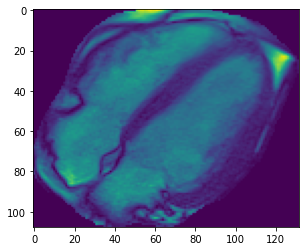

In [278]:
plt.imshow(image[:,:,0]*mask)

In [279]:
l,t = GMM_Thresh(image,mask)

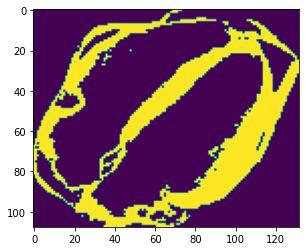

In [280]:
plt.imshow(t[:,:,0])

In [383]:
k = 302
f_image,t_image = FWHM(crop_images[k],crop_masks[k])

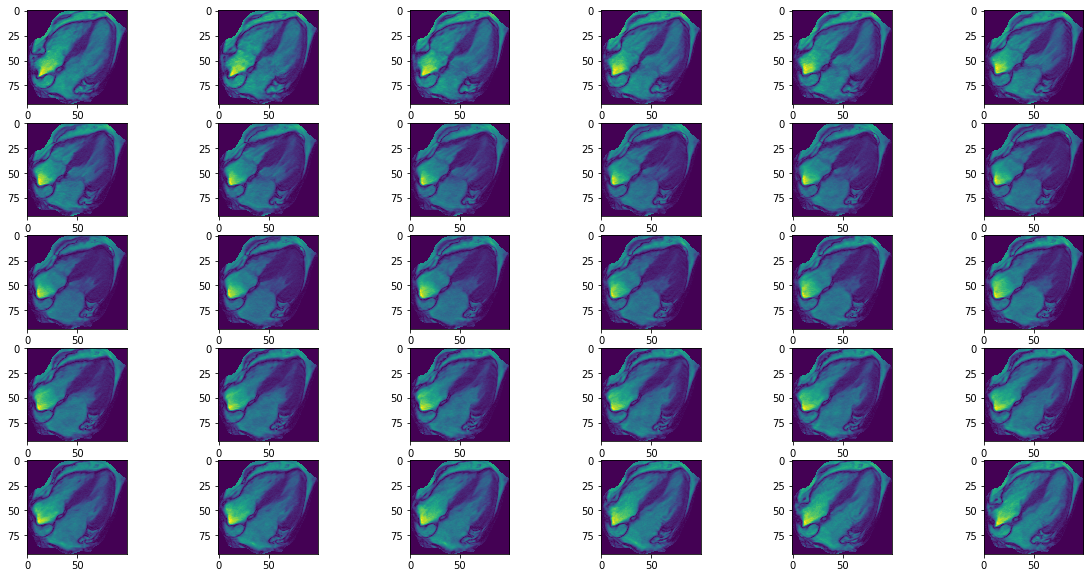

In [384]:
plt.figure(figsize=(20,10))
columns = 6
for i in range(f_image.shape[2]):
    plt.subplot(5, columns, i + 1)
    plt.imshow(crop_images[k][:,:,i]*crop_masks[k])

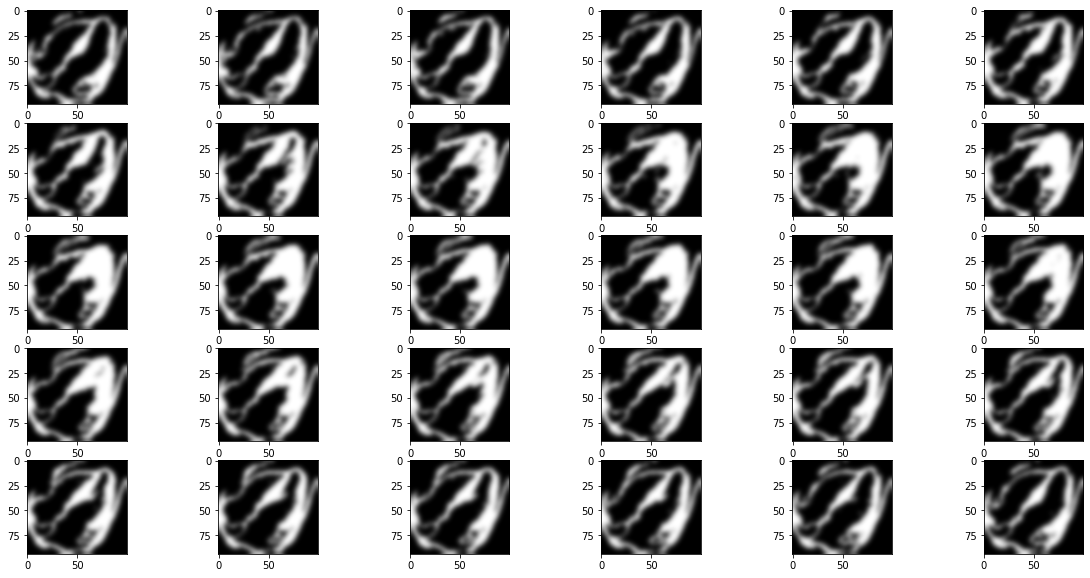

In [385]:
plt.figure(figsize=(20,10))
columns = 6
for i in range(f_image.shape[2]):
    plt.subplot(5, columns, i + 1)
    plt.imshow(f_image[:,:,i], cmap = 'gray')

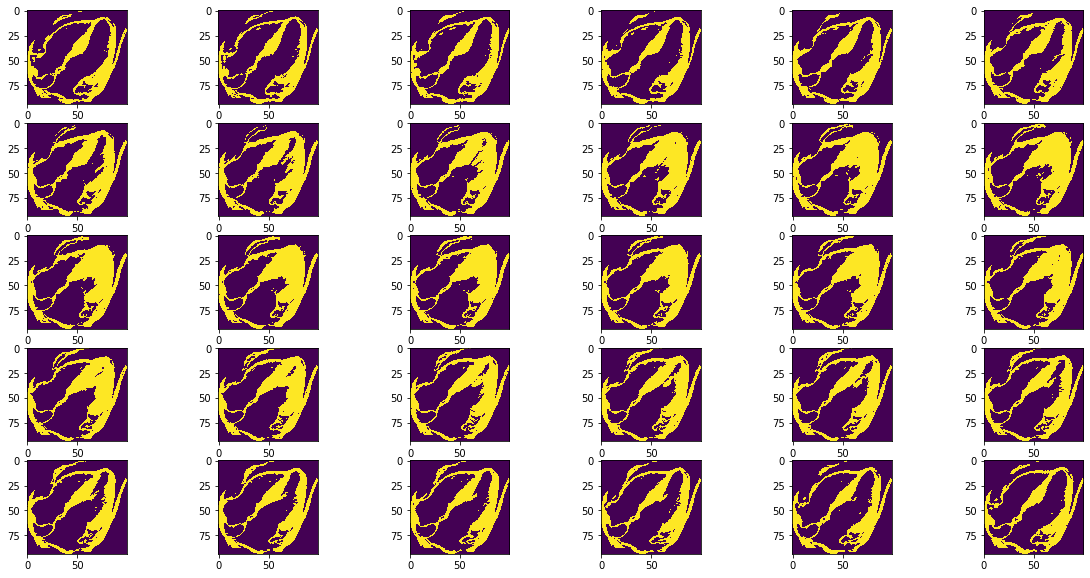

In [386]:
plt.figure(figsize=(20,10))
columns = 6
for i in range(t_image.shape[2]):
    plt.subplot(5, columns, i + 1)
    plt.imshow(t_image[:,:,i])

## Data Augmentation

(array([  6.,  22.,  43.,  94., 118.,  98., 100.,  43.,  21.,   7.]),
 array([102.65625 , 111.265625, 119.875   , 128.484375, 137.09375 ,
        145.703125, 154.3125  , 162.921875, 171.53125 , 180.140625,
        188.75    ]),
 <BarContainer object of 10 artists>)

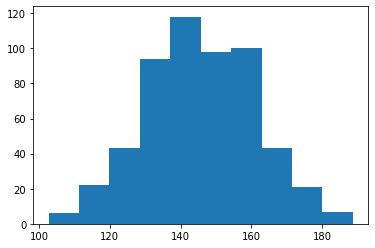

In [26]:
## Histogram of y_lengths
# This suggests that we may need to correct the padding. The largest length
# seems like an outlier and is most likely making us pad the other images too much
plt.hist(Image_df.Y_Length)

(array([ 11.,  51.,  92., 124., 123.,  76.,  44.,  18.,   9.,   4.]),
 array([112.5     , 123.046875, 133.59375 , 144.140625, 154.6875  ,
        165.234375, 175.78125 , 186.328125, 196.875   , 207.421875,
        217.96875 ]),
 <BarContainer object of 10 artists>)

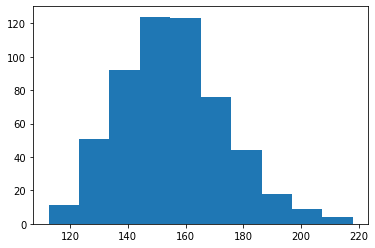

In [27]:
## Histogram of x_lengths
# This suggests that we may need to correct the padding. The largest length
# seems like an outlier and is most likely making us pad the other images too much
plt.hist(Image_df.X_Length)

In [28]:
# Fine largest image within the training set
max_x, max_y = Image_df.X_Length.max(), Image_df.Y_Length.max()
max_l = np.max([max_x,max_y])
Image_df[Image_df['X_Length'] == max_x]

,PatientNumber,RowSpacing,ColumnSpacing,Outcomes,X_res,Y_res,X_Length,Y_Length
334,556,1.40625,1.40625,1,155,122,217.96875,171.5625


In [29]:
max_l

217.96875

## Padding Function

In [30]:
# Function to properly pad images
# Input: Patient, current Y_Length, max y_length in Y direction, desired x and y resolution
# Output: Resized and padded image
def pad(image,d_x_res,d_y_res,C_x_Length,C_y_Length,max_length):
    num_frames = image.shape[2]
    p = d_x_res*(np.max([C_x_Length,C_y_Length]))/max_length
    c_x_res = image.shape[1]
    c_y_res = image.shape[0]
    scale = p/np.max([c_x_res,c_y_res])
    resized_image = np.zeros((d_x_res,d_y_res,num_frames))
    for j in range(num_frames):
        frame = image[:,:,j]
        resized_frame = rescale(frame,scale)
        pad_row = (d_y_res-resized_frame.shape[0])/2
        pad_col = (d_x_res-resized_frame.shape[1])/2
        padded_frame = np.pad(resized_frame,((math.floor(pad_row),math.ceil(pad_row)),
                                             (math.floor(pad_col),math.ceil(pad_col))),'constant')
        resized_image[:,:,j] = padded_frame
    return resized_image

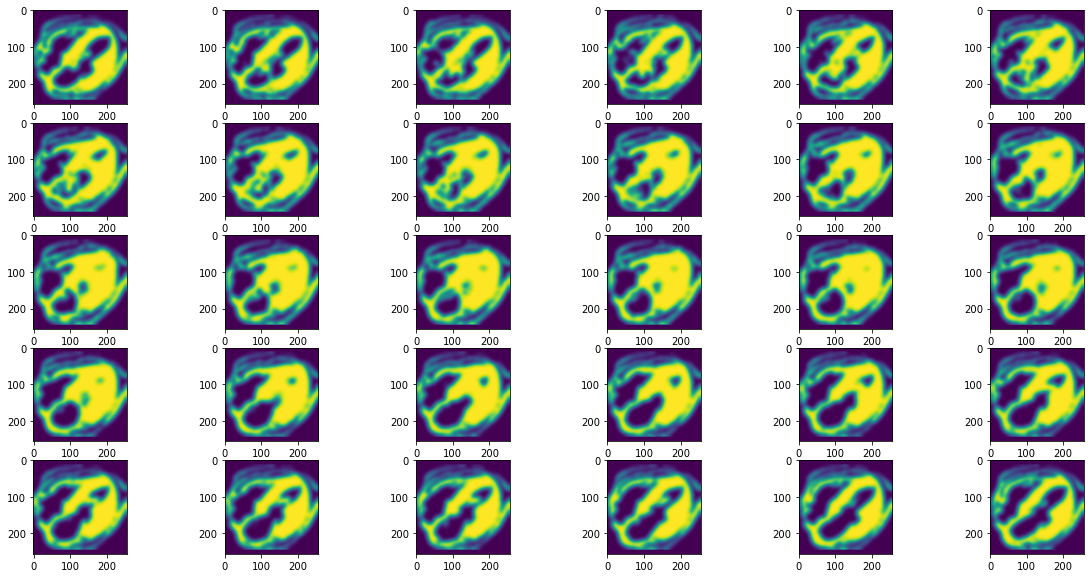

In [31]:
# Load random montage to ensure the padding works correctly
Image = Threshold(crop_images[334],crop_masks[334])
resized_image = pad(Image,256,256,Image_df.X_Length[334],Image_df.Y_Length[334],max_l)
volume = resized_image
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

## Downsampling Function

In [114]:
def downsample(image,X,Y):
    resIM = resize(image,(X,Y))
    return resIM

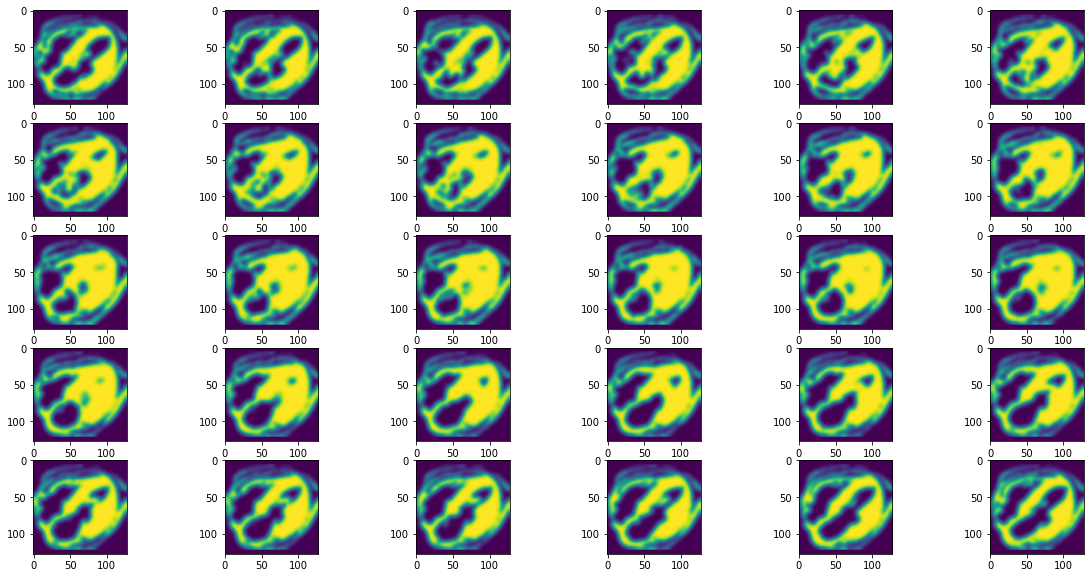

In [33]:
volume  = downsample(resized_image, 128, 128)
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

In [ ]:
Image_df

## Creating Training and Test Sets

In [34]:
IDs = Image_df.PatientNumber.values
Outcomes = Image_df.Outcomes.values

In [35]:
## Make validation set
## Stratified set
sss = m_s.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(IDs, Outcomes):
    print("TRAIN Size:", len(train_index), "Test Size:", len(test_index))

TRAIN Size: 441 Test Size: 111


In [36]:
# Make train df
train_ids = IDs[train_index]
training_df = Image_df[Image_df['PatientNumber'].isin(train_ids)]
training_df

,PatientNumber,RowSpacing,ColumnSpacing,Outcomes,X_res,Y_res,X_Length,Y_Length
0,100,1.250000,1.250000,0,125,125,156.250000,156.250000
1,101,1.250000,1.250000,0,129,108,161.250000,135.000000
2,103,1.250000,1.250000,0,117,107,146.250000,133.750000
3,106,1.406250,1.406250,0,97,85,136.406250,119.531250
4,107,1.250000,1.250000,0,98,104,122.500000,130.000000
...,...,...,...,...,...,...,...,...
633,783,1.250000,1.250000,1,125,117,156.250000,146.250000
634,794,1.250000,1.250000,0,123,118,153.750000,147.500000
635,805,1.339286,1.339286,0,93,105,124.553573,140.625002
636,811,1.406250,1.406250,1,107,105,150.468750,147.656250


In [54]:
# Isolate Training images and outcomes 
crop_images = np.asarray(crop_images, dtype = 'object')
crop_masks = np.asarray(crop_masks, dtype = 'object')
raw_train_images = crop_images[train_index]
train_masks = crop_masks[train_index]
training_labels = Outcomes[train_index]

In [63]:
# Train Images are currently CROPPED but NOT thresholded or padded or reduced to 30 frames if necessary
# Fill the arrays with the images properly padded and processed
# Each image in training_images is 256 x 256 x 30
# ADD the downsampling here
training_images = np.empty((train_index.shape[0],256,256,30))

for i in range(raw_train_images.shape[0]):
    t_image = Threshold(raw_train_images[i],train_masks[i])
    padded_image = pad(t_image,256,256,training_df.X_Length.values[i],training_df.Y_Length.values[i],max_l)
    if padded_image.shape[2] == 50:
        training_images[i] =  HCM.frame_selection(padded_image)
    else:
        training_images[i] = padded_image

In [67]:
#Call Downsampling
training_images1 = np.empty((train_index.shape[0],128,128,30))
for i in range(raw_train_images.shape[0]):
    training_images1[i] = downsample(training_images[i],128,128)
training_images1.shape

(352, 128, 128, 30)

In [ ]:
#Call Filter
training_images2 = np.empty((train_index.shape[0],128,128,30))
for i in range(raw_train_images.shape[0]):
    training_images2[i] = Filter(training_images1[i])
volume  = training_images2[300]
plt.figure(figsize=(20,10))
columns = 6
for i in range(volume.shape[2]):
    image = volume[:,:,i]
    plt.subplot(5, columns, i + 1)
    plt.imshow(image)

In [68]:
## Make validation set
## Stratified set
sss = m_s.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, val_index in sss.split(training_images2, training_labels):
    print("TRAIN Size:", len(train_index), "Val Size:", len(val_index))

TRAIN Size: 281 Val Size: 71


In [79]:
# Making the training and validation sets
sub_train_images, sub_train_labels = training_images2[train_index], training_labels[train_index]
val_images, val_labels = training_images2[val_index], training_labels[val_index]

In [80]:
# Load the images and labels into proper tensor format
train_loader = tf.data.Dataset.from_tensor_slices((sub_train_images, sub_train_labels))
validation_loader = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

In [81]:
# Function to add 4th dimension to image
def add_dim(image, label):
    """Process image by adding a channel."""
    processed_image = tf.expand_dims(image, axis=3)
    return processed_image, label

In [82]:
batch_size = 10
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(sub_train_images))
    .map(add_dim)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(val_images))
    .map(add_dim)
    .batch(batch_size)
    .prefetch(2)
)

## CNN

In [124]:
# Currently Assuming that the input images are 150x150 with 30 frames
# Channel = 1 because they are grayscale
# This architecure is DEFINITELY subject to change

# Input Data
input_data = layers.Input([128,128,30,1])
initializer1 = tf.keras.initializers.he_normal()
initializer2 = tf.keras.initializers.GlorotNormal()

# Conv 1.1
encoder = Conv3D(4,(6,6,3), strides=(2,2,1), activation="relu",padding = "same", kernel_initializer = initializer1)(input_data)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(4,(6,6,3), strides=(2,2,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,2), strides=(2,2,2))(encoder)

# Conv 2.1
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(8,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (2,2,3), strides=(2,2,3))(encoder)

# Size of data after convolutional layers
volumesize = tf.keras.backend.int_shape(encoder)

# Fully Connected
# 1st layer
encoder = Flatten()(encoder)
dense1_size = tf.keras.backend.int_shape(encoder)

# We may need an extra layer here

# 2nd layer
encoder = layers.Dense(100,activation = 'relu', kernel_initializer = initializer1)(encoder)

# Dropout
encoder = layers.Dropout(0.2)(encoder)

# Classifying layer
encoder_cnn = layers.Dense(1,activation = 'sigmoid', kernel_initializer = initializer2)(encoder)

# Summary of the encoder 
model = tf.keras.Model(input_data, encoder_cnn, name="HCM_CNN")
model.summary()

Model: "HCM_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 30, 1)] 0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 64, 64, 30, 4)     436       
_________________________________________________________________
batch_normalization_32 (Batc (None, 64, 64, 30, 4)     16        
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 32, 32, 30, 4)     1732      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 30, 4)     16        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 16, 16, 15, 4)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 16, 16, 15, 8)     872 

In [ ]:
# 3rd Convolutional Layer
# (Needs to be edited to be compatible with first 2 layers)
# Conv 3.1
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = Conv3D(16,(3,3,3), strides=(1,1,1), activation="relu",padding = "same", kernel_initializer = initializer1)(encoder)
encoder = BatchNormalization(center=True, scale=True)(encoder)
encoder = MaxPooling3D(pool_size = (4,4,5), strides=(4,4,5), padding = "same")(encoder)

In [125]:
# Summary of the encoder 
model = tf.keras.Model(input_data, encoder_cnn, name="HCM_CNN")
model.summary()

Model: "HCM_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 30, 1)] 0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 64, 64, 30, 4)     436       
_________________________________________________________________
batch_normalization_32 (Batc (None, 64, 64, 30, 4)     16        
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 32, 32, 30, 4)     1732      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 30, 4)     16        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 16, 16, 15, 4)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 16, 16, 15, 8)     872 

In [127]:
## F1 function to calculate F1 score each epoch
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [128]:
# Compile model.
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy',  metrics.Recall(thresholds=0.5), metrics.Precision(thresholds = 0.5),metrics.TruePositives(thresholds = 0.5), metrics.TrueNegatives(0.5), metrics.FalsePositives(thresholds = 0.5), metrics.FalseNegatives(thresholds=0.5)],
)

In [129]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg = len(training_labels[training_labels == 0])
pos = len(training_labels[training_labels == 1])
total = len(training_labels)
weight_for_0 = -math.log((1 / neg)*(total)/2.0)
weight_for_1 = math.log((1 / pos)*(total)/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.45
Weight for class 1: 0.85


In [130]:
# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor= 'loss', patience=4)

# Train the model, doing validation at the end of each epoch
epochs = 30
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
    class_weight = class_weight
)

Epoch 1/30
29/29 - 2s - loss: 0.7571 - accuracy: 0.6548 - f1_metric: 0.1091 - val_loss: 0.6976 - val_accuracy: 0.4366 - val_f1_metric: 0.3188
Epoch 2/30
29/29 - 1s - loss: 0.3214 - accuracy: 0.7758 - f1_metric: 0.2253 - val_loss: 0.8001 - val_accuracy: 0.1831 - val_f1_metric: 0.3479
Epoch 3/30
29/29 - 1s - loss: 0.3221 - accuracy: 0.7758 - f1_metric: 0.1951 - val_loss: 1.0590 - val_accuracy: 0.2113 - val_f1_metric: 0.2698
Epoch 4/30
29/29 - 1s - loss: 0.2998 - accuracy: 0.8149 - f1_metric: 0.2826 - val_loss: 1.0529 - val_accuracy: 0.1972 - val_f1_metric: 0.2698
Epoch 5/30
29/29 - 1s - loss: 0.2616 - accuracy: 0.8399 - f1_metric: 0.4080 - val_loss: 1.0694 - val_accuracy: 0.2254 - val_f1_metric: 0.2490
Epoch 6/30
29/29 - 1s - loss: 0.2702 - accuracy: 0.8043 - f1_metric: 0.3709 - val_loss: 0.6718 - val_accuracy: 0.6056 - val_f1_metric: 0.2574
Epoch 7/30
29/29 - 1s - loss: 0.2368 - accuracy: 0.8292 - f1_metric: 0.4312 - val_loss: 0.6884 - val_accuracy: 0.5775 - val_f1_metric: 0.2603
Epoch 

In [1]:
#the number at the end of val_true_positive etc changes after each instance. 
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(history.history['val_loss'])
plt.title('val_loss')
plt.subplot(1,3,2)
plt.plot(history.history['val_true_positives_9'])
plt.title('val_true_positives_9')
plt.subplot(1,3,3)
plt.plot(history.history['val_true_negatives_9'])
plt.title('val_true_negatives_9')

NameError: name 'tfdocs' is not defined

In [131]:
prediction = model.predict(val_images, batch_size = 1)

In [132]:
np.sum(val_labels == 1)

15

In [142]:
prediction[val_labels == 1]

array([[0.5028579 ],
       [0.65588504],
       [0.34497744],
       [0.21082637],
       [0.3712777 ],
       [0.12540556],
       [0.13616826],
       [0.60514534],
       [0.62841064],
       [0.10990667],
       [0.63519657],
       [0.19362377],
       [0.5983366 ],
       [0.28382802],
       [0.22546893]], dtype=float32)

In [157]:
#Predict the F1 score for predicted validation label and the true validation labels
p5 = []
for val in (prediction):
    p5.append(val[0])
    
#The last layer activation function is sigmoid, therefore predicted labels are  in the range of [0,1]
#Calculate the "labels" from the probability (output of the sigmoid function) with the threshold assumption of 0.5
val_labels_predicted = np.asarray(p5)>0.5
#predicted labels
y_pred = val_labels_predicted.astype(int)
#true labels
y_true = val_labels.astype(int)
#calculate the f1 score for true positive
from sklearn.metrics import f1_score
f1_score(y_true, y_pred)

0.3076923076923077

In [96]:
prediction = model.predict(np.expand_dims(val_images[28], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]
scores

[0.7364880740642548, 0.26351193]

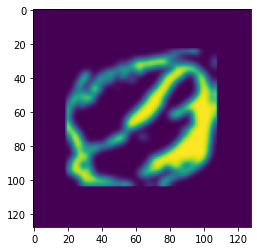

In [97]:
plt.imshow(val_images[28][:,:,20])

## Model Visualization

In [98]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_3',
 'conv3d_8',
 'batch_normalization_8',
 'conv3d_9',
 'batch_normalization_9',
 'max_pooling3d_4',
 'conv3d_10',
 'batch_normalization_10',
 'conv3d_11',
 'batch_normalization_11',
 'max_pooling3d_5',
 'flatten_2',
 'dense_4',
 'dense_5']

## Model visualization

In [99]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_3',
 'conv3d_8',
 'batch_normalization_8',
 'conv3d_9',
 'batch_normalization_9',
 'max_pooling3d_4',
 'conv3d_10',
 'batch_normalization_10',
 'conv3d_11',
 'batch_normalization_11',
 'max_pooling3d_5',
 'flatten_2',
 'dense_4',
 'dense_5']

In [100]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<tf.Tensor 'input_3:0' shape=(None, 128, 128, 30, 1) dtype=float32>,
 <tf.Tensor 'conv3d_8/Relu:0' shape=(None, 128, 128, 30, 4) dtype=float32>,
 <tf.Tensor 'batch_normalization_8/batchnorm/add_1:0' shape=(None, 128, 128, 30, 4) dtype=float32>,
 <tf.Tensor 'conv3d_9/Relu:0' shape=(None, 128, 128, 30, 4) dtype=float32>,
 <tf.Tensor 'batch_normalization_9/batchnorm/add_1:0' shape=(None, 128, 128, 30, 4) dtype=float32>,
 <tf.Tensor 'max_pooling3d_4/MaxPool3D:0' shape=(None, 64, 64, 15, 4) dtype=float32>,
 <tf.Tensor 'conv3d_10/Relu:0' shape=(None, 64, 64, 15, 8) dtype=float32>,
 <tf.Tensor 'batch_normalization_10/batchnorm/add_1:0' shape=(None, 64, 64, 15, 8) dtype=float32>,
 <tf.Tensor 'conv3d_11/Relu:0' shape=(None, 64, 64, 15, 8) dtype=float32>,
 <tf.Tensor 'batch_normalization_11/batchnorm/add_1:0' shape=(None, 64, 64, 15, 8) dtype=float32>,
 <tf.Tensor 'max_pooling3d_5/MaxPool3D:0' shape=(None, 32, 32, 5, 8) dtype=float32>,
 <tf.Tensor 'flatten_2/Reshape:0' shape=(None, 40960) dtype

In [101]:
#recreate a network and predict the outputs of each layer with an image
feature_map_model = tf.keras.models.Model(inputs=input_data, outputs=layer_outputs)
image1 = val_images[1,:,:,:]
image2 = tf.expand_dims(image1, axis=3)
image2 = tf.expand_dims(image1, axis=0)
print(val_images.shape, image1.shape, image2.shape)
feature_maps = feature_map_model.predict(image2)
len(feature_maps)

(71, 128, 128, 30) (128, 128, 30) (1, 128, 128, 30)


14

In [102]:
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the input_3 is =======>> (1, 128, 128, 30, 1)
The shape of the conv3d_8 is =======>> (1, 128, 128, 30, 4)
The shape of the batch_normalization_8 is =======>> (1, 128, 128, 30, 4)
The shape of the conv3d_9 is =======>> (1, 128, 128, 30, 4)
The shape of the batch_normalization_9 is =======>> (1, 128, 128, 30, 4)
The shape of the max_pooling3d_4 is =======>> (1, 64, 64, 15, 4)
The shape of the conv3d_10 is =======>> (1, 64, 64, 15, 8)
The shape of the batch_normalization_10 is =======>> (1, 64, 64, 15, 8)
The shape of the conv3d_11 is =======>> (1, 64, 64, 15, 8)
The shape of the batch_normalization_11 is =======>> (1, 64, 64, 15, 8)
The shape of the max_pooling3d_5 is =======>> (1, 32, 32, 5, 8)
The shape of the flatten_2 is =======>> (1, 40960)
The shape of the dense_4 is =======>> (1, 100)
The shape of the dense_5 is =======>> (1, 1)


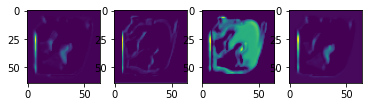

In [110]:
conv_l = [1,7] #first 2 convolutional layers
slice = 8
channel = 4
feature_image1 = feature_image = feature_maps[conv_l[0]]
feature_image2 = feature_image = feature_maps[conv_l[1]]

columns = channel
for i in range(channel):
    plt.subplot(1, columns, i + 1)
    plt.imshow(feature_image2[0,:,:,slice,i + 1])